In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of 30 diversified assets
tickers = [
    "AAPL", "MSFT", "GOOG", "META", "AMZN",
    "NVDA", "TSLA", "NFLX", "AMD", "INTC",
    "SPY", "QQQ", "DIA", "IWM", "VTI",
    "XLF", "XLE", "XLV", "XLK", "XLY",
    "ARKK", "GLD", "SLV", "USO", "TLT",
    "BTC-USD", "ETH-USD", "VIXY", "GDX", "UUP"
]

start_date = "2020-01-01"
end_date = "2023-12-31"

# Download all data
raw_data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker", auto_adjust=False)

# Extract only 'Adj Close' for each ticker
adj_close = pd.DataFrame()

for ticker in tickers:
    try:
        ticker_data = raw_data[ticker]["Adj Close"]
        adj_close[ticker] = ticker_data
    except (KeyError, TypeError):
        print(f"⚠️ Skipping missing or malformed data for: {ticker}")

# Convert to monthly returns
adj_close.index = pd.to_datetime(adj_close.index)
monthly_returns = adj_close.resample("M").ffill().pct_change().dropna()

print("Shape of monthly return dataset:", monthly_returns.shape)
display(monthly_returns.head())


[                       0%                       ]

[*********************100%***********************]  30 of 30 completed

Shape of monthly return dataset: (47, 30)



C:\Users\gracj\AppData\Local\Temp\ipykernel_18372\3753879250.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = adj_close.resample("M").ffill().pct_change().dropna()
C:\Users\gracj\AppData\Local\Temp\ipykernel_18372\3753879250.py:34: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = adj_close.resample("M").ffill().pct_change().dropna()


,AAPL,MSFT,GOOG,META,AMZN,NVDA,TSLA,NFLX,AMD,INTC,...,ARKK,GLD,SLV,USO,TLT,BTC-USD,ETH-USD,VIXY,GDX,UUP
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080319,0.220295,0.000000,0.000000,0.000000
2020-03-31,-0.176461,-0.071017,-0.189244,-0.173889,-0.029372,0.115585,-0.194552,0.088122,-0.032340,-0.149280,...,-0.150579,-0.008572,-0.224138,-0.611624,0.134258,-0.251278,-0.392338,1.836948,-0.205243,0.020928
2020-04-30,0.155374,0.136326,0.159829,0.227278,0.268900,0.108801,0.492137,0.118109,0.151935,0.108278,...,0.257500,0.072611,0.071264,-0.432304,0.012190,0.344779,0.553982,-0.180859,0.400173,-0.001491
2020-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.092683,0.112589,0.000000,0.000000,0.000000
2020-06-30,0.245022,0.138758,0.048159,0.109228,0.115125,0.300408,0.381043,0.083816,0.004199,0.003134,...,0.288812,0.053967,0.216738,0.467573,-0.014312,-0.034147,-0.020178,-0.106534,0.137012,-0.017544


In [3]:
# --- Portfolio KPI computation block ---

def compute_portfolio_metrics(weights, returns_df):
    """
    Given weights and asset returns, compute portfolio KPIs.
    weights: list or np.array of floats summing to 1
    returns_df: DataFrame of historical monthly returns
    """
    weights = np.array(weights)
    portfolio_returns = returns_df.dot(weights)

    # Expected return (mean monthly return)
    expected_return = portfolio_returns.mean()

    # Volatility (standard deviation)
    volatility = portfolio_returns.std()

    # Profit Factor = total profit / total loss
    gains = portfolio_returns[portfolio_returns > 0].sum()
    losses = -portfolio_returns[portfolio_returns < 0].sum()
    profit_factor = gains / losses if losses != 0 else np.inf

    # Expectancy = WinRate * AvgWin - LossRate * AvgLoss
    wins = portfolio_returns[portfolio_returns > 0]
    losses_vals = portfolio_returns[portfolio_returns < 0]
    win_rate = len(wins) / len(portfolio_returns)
    loss_rate = 1 - win_rate
    avg_win = wins.mean() if not wins.empty else 0
    avg_loss = abs(losses_vals.mean()) if not losses_vals.empty else 0
    expectancy = (win_rate * avg_win) - (loss_rate * avg_loss)

    # Max Drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()

    return {
        "Expected Return": expected_return,
        "Volatility": volatility,
        "Profit Factor": profit_factor,
        "Expectancy": expectancy,
        "Max Drawdown": max_drawdown,
        "Fitness": calculate_fitness(expected_return, volatility, profit_factor, expectancy, max_drawdown)
    }


def calculate_fitness(expected_return, volatility, profit_factor, expectancy, max_drawdown):
    """
    Combine KPIs into a single fitness score.
    You can tune the weights of each component based on goals.
    """
    return (
        expected_return * 3
        - volatility * 2
        + profit_factor * 1
        + expectancy * 2
        - abs(max_drawdown) * 3
    )


In [4]:
# --- Test example: random portfolio evaluation ---

def generate_random_weights(n_assets):
    """
    Generate random weights that sum to 1
    """
    weights = np.random.random(n_assets)
    return weights / np.sum(weights)

# Generate weights for 30 assets (same as in monthly_returns)
random_weights = generate_random_weights(monthly_returns.shape[1])

# Evaluate portfolio KPIs
metrics = compute_portfolio_metrics(random_weights, monthly_returns)

# Display results
print("Random Portfolio KPIs:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Random Portfolio KPIs:
Expected Return: 0.0186
Volatility: 0.0618
Profit Factor: 2.1792
Expectancy: 0.0186
Max Drawdown: -0.2840
Fitness: 1.2966


In [5]:
# --- Genetic Algorithm Core ---
import random 

def initialize_population(n_individuals, n_assets):
    return [generate_random_weights(n_assets) for _ in range(n_individuals)]

def crossover(parent1, parent2):
    """
    Single-point crossover + normalization
    """
    if len(parent1) < 3:
        return parent1  
    point = np.random.randint(1, len(parent1) - 1)
    child = np.concatenate((parent1[:point], parent2[point:]))
    return child / np.sum(child)

def mutate(weights, mutation_rate=0.1):
    """
    Mutate portfolio by adding noise and re-normalizing
    """
    mutated = weights + np.random.normal(0, mutation_rate, len(weights))
    mutated = np.clip(mutated, 0, None)  # no negative weights
    return mutated / np.sum(mutated)

def select_elite(population, fitnesses, elite_size):
    """
    Select top-performing individuals
    """
    sorted_indices = np.argsort(fitnesses)[::-1]
    return [population[i] for i in sorted_indices[:elite_size]]

def run_genetic_algorithm(
    returns_df,
    n_generations=50,
    n_individuals=100,
    elite_size=10,
    mutation_rate=0.05
):
    n_assets = returns_df.shape[1]
    population = initialize_population(n_individuals, n_assets)
    best_fitness_progress = []

    for generation in range(n_generations):
        fitnesses = [
            compute_portfolio_metrics(ind, returns_df)["Fitness"]
            for ind in population
        ]

        best_fitness = np.max(fitnesses)
        best_fitness_progress.append(best_fitness)

        elites = select_elite(population, fitnesses, elite_size)

        new_population = elites.copy()

        while len(new_population) < n_individuals:
            import random  # Make sure this is imported
            parent1, parent2 = random.sample(elites, 2)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)

        population = new_population

    # Final best individual
    final_fitnesses = [
        compute_portfolio_metrics(ind, returns_df)["Fitness"]
        for ind in population
    ]
    best_index = np.argmax(final_fitnesses)
    best_weights = population[best_index]
    best_metrics = compute_portfolio_metrics(best_weights, returns_df)

    return best_weights, best_metrics, best_fitness_progress



In [6]:
best_weights, best_metrics, fitness_curve = run_genetic_algorithm(
    monthly_returns,
    n_generations=50,
    n_individuals=100,
    elite_size=10,
    mutation_rate=0.03
)

print("\nBest Portfolio Metrics:")
for key, value in best_metrics.items():
    print(f"{key}: {value:.4f}")



Best Portfolio Metrics:
Expected Return: 0.0126
Volatility: 0.0277
Profit Factor: 4.6969
Expectancy: 0.0073
Max Drawdown: -0.0903
Fitness: 4.4231


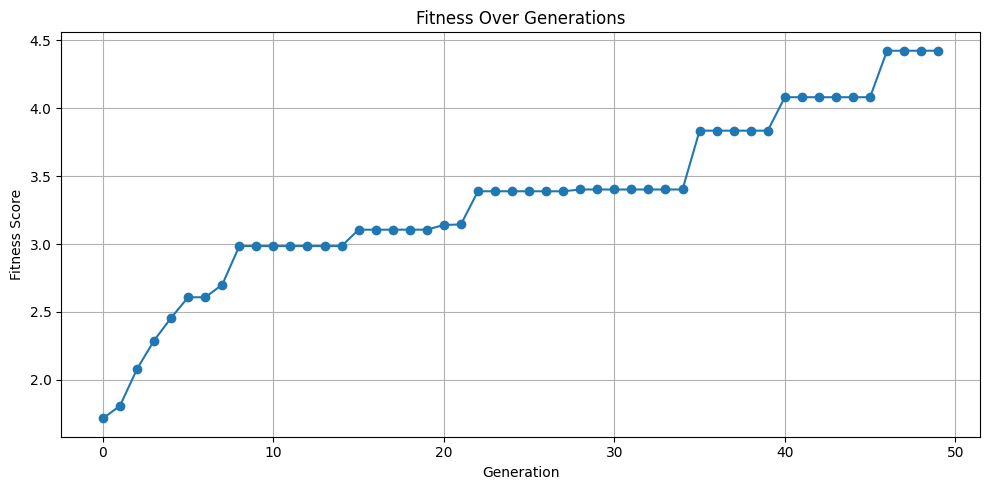

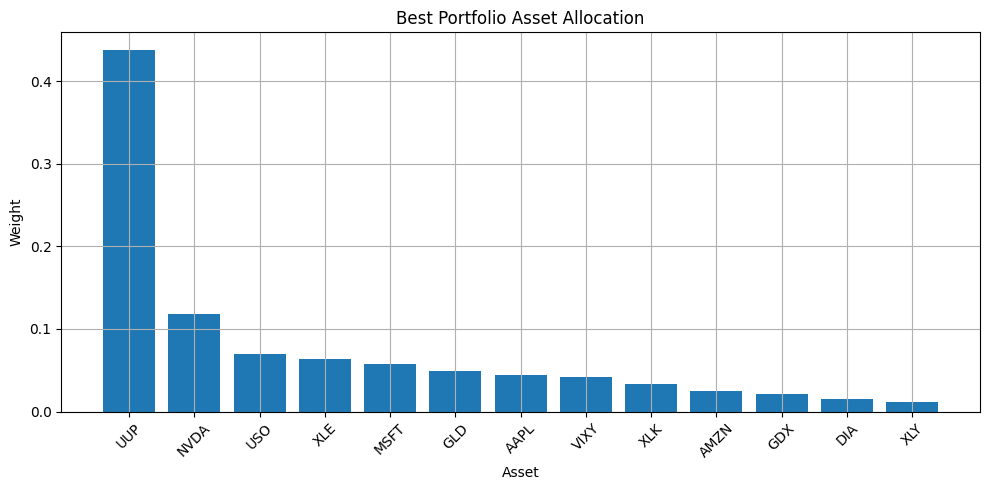

In [7]:
# --- Visualizations ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have:
# - fitness_curve
# - best_weights
# - tickers (the same list of 30 used earlier)

# Plot fitness over generations
plt.figure(figsize=(10, 5))
plt.plot(fitness_curve, marker='o')
plt.title("Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create DataFrame for best portfolio allocation
portfolio_df = pd.DataFrame({
    "Ticker": tickers,
    "Weight": best_weights
})

# Filter to show only assets with weight > 1%
portfolio_df = portfolio_df[portfolio_df["Weight"] > 0.01]
portfolio_df = portfolio_df.sort_values("Weight", ascending=False)

# Plot best portfolio weights
plt.figure(figsize=(10, 5))
plt.bar(portfolio_df["Ticker"], portfolio_df["Weight"])
plt.title("Best Portfolio Asset Allocation")
plt.ylabel("Weight")
plt.xlabel("Asset")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


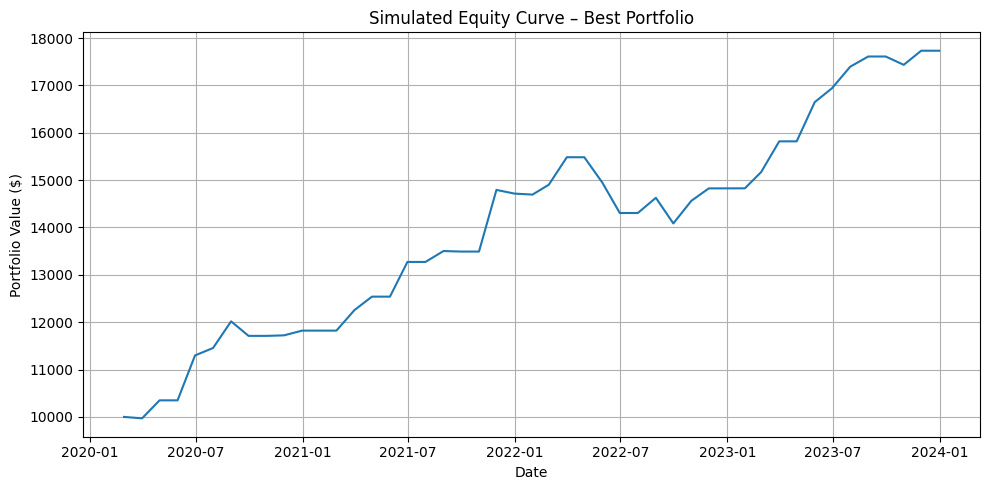

In [8]:
# --- Simulated Equity Curve ---

# 1. Calculate portfolio monthly returns using best weights
portfolio_returns = monthly_returns.dot(best_weights)

# 2. Simulate equity curve with monthly compounding
initial_capital = 10_000  # Starting capital
equity_curve = (1 + portfolio_returns).cumprod() * initial_capital

# 3. Plot the equity curve
plt.figure(figsize=(10, 5))
plt.plot(equity_curve.index, equity_curve.values)
plt.title("Simulated Equity Curve – Best Portfolio")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# --- Imports required globally ---
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Genetic Algorithm Utilities ---
def generate_random_weights(n):
    w = np.random.rand(n)
    return w / np.sum(w)

def crossover(p1, p2):
    if len(p1) < 3:
        return p1
    point = np.random.randint(1, len(p1) - 1)
    child = np.concatenate([p1[:point], p2[point:]])
    return child / np.sum(child)

def mutate(w, rate=0.05):
    noise = np.random.normal(0, rate, size=len(w))
    w = np.clip(w + noise, 0, None)
    return w / np.sum(w)

def custom_fitness_func(w, r, v, pf, e, dd, weights):
    return (
        weights["ret"] * r -
        weights["vol"] * v +
        weights["pf"] * pf +
        weights["exp"] * e -
        weights["dd"] * abs(dd)
    )

def compute_kpis(weights, returns_df, weights_dict):
    port = returns_df.dot(weights)
    if len(port.dropna()) == 0:
        return -np.inf

    r = port.mean()
    v = port.std()
    gains = port[port > 0]
    losses = port[port < 0]
    pf = gains.sum() / -losses.sum() if losses.sum() != 0 else np.inf

    win_rate = len(gains) / len(port) if len(port) > 0 else 0
    loss_rate = 1 - win_rate
    avg_win = gains.mean() if not gains.empty else 0
    avg_loss = abs(losses.mean()) if not losses.empty else 0
    expectancy = win_rate * avg_win - loss_rate * avg_loss

    cumulative = (1 + port).cumprod()
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    mdd = dd.min()

    return custom_fitness_func(weights, r, v, pf, expectancy, mdd, weights_dict)

def run_simple_GA(returns_df, weights_dict, gens=50, pop_size=100):
    n_assets = returns_df.shape[1]
    population = [generate_random_weights(n_assets) for _ in range(pop_size)]
    fitness_history = []

    for _ in range(gens):
        fitnesses = [compute_kpis(ind, returns_df, weights_dict) for ind in population]
        elite = [population[i] for i in np.argsort(fitnesses)[-10:]]
        new_pop = elite[:]

        while len(new_pop) < pop_size:
            p1, p2 = random.sample(elite, 2)
            c = crossover(p1, p2)
            c = mutate(c)
            new_pop.append(c)

        population = new_pop
        fitness_history.append(max(fitnesses))

    final_fitnesses = [compute_kpis(ind, returns_df, weights_dict) for ind in population]
    best = population[np.argmax(final_fitnesses)]
    return best, fitness_history


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import random
import datetime

# === UI Elements ===

risk_selector = widgets.Dropdown(
    options=["Conservative", "Balanced", "Aggressive"],
    value="Balanced",
    description="Risk Profile:"
)

start_picker = widgets.DatePicker(
    description='Start Date',
    value=datetime.date(2020, 1, 1),
    disabled=False,
    max=datetime.date(2025, 5, 1)
)

end_picker = widgets.DatePicker(
    description='End Date',
    value=datetime.date(2023, 12, 31)
)

gens_slider = widgets.IntSlider(
    value=50, min=10, max=200, step=10,
    description="Generations:",
    style={'description_width': 'initial'}
)

pop_slider = widgets.IntSlider(
    value=100, min=20, max=200, step=10,
    description="Population:",
    style={'description_width': 'initial'}
)

mut_slider = widgets.FloatSlider(
    value=0.05, min=0.0, max=0.3, step=0.01,
    description="Mutation Rate:",
    style={'description_width': 'initial'}
)


run_button = widgets.Button(description="Run Optimization", button_style="success")
out = widgets.Output()

ui_box = widgets.VBox([
    risk_selector,
    widgets.HBox([start_picker, end_picker]),
    gens_slider,
    pop_slider,
    mut_slider,
    run_button,
    out
])

display(ui_box)

# === GA Utility Functions (assumed present in the notebook) ===
# generate_random_weights, crossover, mutate, custom_fitness_func, compute_kpis, run_simple_GA
# If you want me to re-include those functions here too, let me know.

# === Risk profile assets and weights ===
def get_assets_and_weights(profile):
    if profile == "Conservative":
        assets = ["TLT", "GLD", "VTI", "XLF", "XLV", "USO", "QQQ", "SLV", "UUP", "DIA"]
        weights = {"ret": 2, "vol": 4, "pf": 1, "exp": 2, "dd": 4}
    elif profile == "Aggressive":
        assets = ["BTC-USD", "ETH-USD", "TSLA", "ARKK", "NVDA", "AMZN", "GDX", "SPY", "QQQ", "META"]
        weights = {"ret": 5, "vol": 1, "pf": 2, "exp": 3, "dd": 2}
    else:
        assets = ["AAPL", "MSFT", "GOOG", "SPY", "QQQ", "GLD", "XLK", "VTI", "TLT", "USO"]
        weights = {"ret": 3, "vol": 2, "pf": 1, "exp": 2, "dd": 3}
    return assets, weights

def extract_kpis(weights, returns_df):
    port = returns_df.dot(weights)
    r = port.mean()
    v = port.std()
    gains = port[port > 0]
    losses = port[port < 0]
    pf = gains.sum() / -losses.sum() if losses.sum() != 0 else np.inf

    win_rate = len(gains) / len(port) if len(port) > 0 else 0
    loss_rate = 1 - win_rate
    avg_win = gains.mean() if not gains.empty else 0
    avg_loss = abs(losses.mean()) if not losses.empty else 0
    expectancy = win_rate * avg_win - loss_rate * avg_loss

    cumulative = (1 + port).cumprod()
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    mdd = dd.min()

    fitness = custom_fitness_func(weights, r, v, pf, expectancy, mdd, {
        "ret": 1, "vol": 1, "pf": 1, "exp": 1, "dd": 1
    })


    return {
        "Expected Return": r,
        "Volatility": v,
        "Profit Factor": pf,
        "Expectancy": expectancy,
        "Max Drawdown": mdd,
        "Fitness": fitness
    }


# === Main Optimization Callback ===
def run_risk_profile_optimization(b):
    with out:
        out.clear_output()
        profile = risk_selector.value
        tickers, weights_dict = get_assets_and_weights(profile)

        print(f"\nSelected profile: {profile} – using {len(tickers)} assets")

        # Enforced date range
        start_date = pd.to_datetime(start_picker.value)
        end_date = pd.to_datetime(end_picker.value)
        min_allowed_date = pd.to_datetime("2015-01-01")

        # Safety check for minimum start date
        if start_date < min_allowed_date:
            print("Start date too early. Please choose a date after 2015-01-01.")
            return

        print(f"Date range: {start_date.date()} to {end_date.date()}")
        print(f"GA: generations={gens_slider.value}, pop={pop_slider.value}, mutation={mut_slider.value}")

        # Download with enforced start
        data = yf.download(tickers, start=start_date, end=end_date)

        # # Debug output to inspect the structure
        # print("\nData column structure:")
        # print(data.columns)

        # print("\nFirst few rows:")
        # print(data.head())

        # # Try to extract Adjusted Close properly
        # if isinstance(data.columns, pd.MultiIndex):
        #     print("\nDetected MultiIndex columns.")
        #     if "Close" in data.columns.levels[0]:
        #         adj_close = data["Close"]
        #         print("Extracted 'Close' prices as adjusted close.")
        #     else:
        #         print("Could not find 'Close' level in MultiIndex.")
        #         return
        # else:
        #     print("No MultiIndex — assuming flat format is Adjusted Close.")
        #     adj_close = data

        # Handle MultiIndex (Yahoo returns OHLCV)
        if isinstance(data.columns, pd.MultiIndex):
            if "Close" in data.columns.levels[0]:
                adj_close = data["Close"]
            else:
                print("Could not find 'Close' prices in downloaded data.")
                return
        else:
            adj_close = data

        # Drop assets that failed
        adj_close = adj_close.dropna(axis=1, thresh=int(0.65 * len(adj_close)))
        print(f"Retrieved data for {adj_close.shape[1]} assets")

        adj_close.index = pd.to_datetime(adj_close.index)
        returns = adj_close.resample("ME").ffill().pct_change(fill_method=None).dropna()


        if returns.shape[1] < 3:
            print("Not enough valid assets after filtering. Try a different profile.")
            return

        best_weights, fit_curve = run_simple_GA(
            returns, 
            weights_dict, 
            gens=gens_slider.value, 
            pop_size=pop_slider.value
        )

        print("\nBest portfolio found.")

        # Prepare allocation table
        pf_df = pd.DataFrame({"Ticker": returns.columns, "Weight": best_weights})
        pf_df = pf_df[pf_df["Weight"] > 0.01].sort_values("Weight", ascending=False)

        # Print portfolio allocation before showing charts
        print("\nBest Portfolio Allocation (Weights > 1%):")
        for ticker, weight in zip(pf_df["Ticker"], pf_df["Weight"]):
            print(f"  {ticker:<6}: {weight:.2%}")

        # Extract and print KPIs
        kpis = extract_kpis(best_weights, returns)

        print("\nPortfolio KPIs:")
        for key, value in kpis.items():
            if key in ["Expected Return", "Volatility", "Expectancy", "Max Drawdown"]:
                print(f"  {key:<16}: {value:.2%}")
            else:
                print(f"  {key:<16}: {value:.4f}")


        # Fitness chart
        plt.figure(figsize=(10, 4))
        plt.plot(fit_curve)
        plt.title("Fitness Over Generations")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Allocation chart
        plt.figure(figsize=(10, 4))
        plt.bar(pf_df["Ticker"], pf_df["Weight"])
        plt.title("Best Portfolio Allocation")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Equity curve
        equity_curve = (1 + returns.dot(best_weights)).cumprod() * 10000
        plt.figure(figsize=(10, 4))
        plt.plot(equity_curve)
        plt.title("Simulated Equity Curve")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Connect button
run_button.on_click(run_risk_profile_optimization)


[**********************90%******************     ]  9 of 10 completed

[**********************80%*************          ]  8 of 10 completed